In [1]:
import numpy as np
import pickle

In [238]:
class BlackJackSolution:

    def __init__(self, lr=0.1, exp_rate=0.3):
        self.player_Q_Values = {}  # key: [(player_value, show_card, usable_ace)][action] = value
        # initialise Q values | (12-21) x (1-10) x (True, False) x (1, 0) 400 in total
        for i in range(12, 22):
            for j in range(1, 11):
                for k in [True, False]:
                    self.player_Q_Values[(i, j, k)] = {}
                    for a in [1, 0]:
                        if (i == 21) and (a == 0):
                            self.player_Q_Values[(i, j, k)][a] = 1
                        else:
                            self.player_Q_Values[(i, j, k)][a] = 0

        self.player_state_action = []
        self.state = (0, 0, False)  # initial state
        self.actions = [1, 0]  # 1: HIT  0: STAND
        self.end = False
        self.lr = lr
        self.exp_rate = exp_rate
        
        # Added attribute to keep track of how well the model is learning
        self.gameTrack = []

    # give card
    @staticmethod
    def giveCard():
        # 1 stands for ace
        c_list = list(range(1, 11)) + [10, 10, 10]
        return np.random.choice(c_list)

    def dealerPolicy(self, current_value, usable_ace, is_end):
        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                return current_value, usable_ace, True
        # HIT17
        if current_value >= 17:
            return current_value, usable_ace, True
        else:
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    return current_value + 11, True, False
                return current_value + 1, usable_ace, False
            else:
                return current_value + card, usable_ace, False

    def chooseAction(self,round=0,trainRound=1000):
        # if current value <= 11, always hit
        current_value = self.state[0]
        if current_value <= 11:
            return 1

        if np.random.uniform(0, 1) <= (self.exp_rate*(1 - round/trainRound)):
            action = np.random.choice(self.actions)
        #             print("random action", action)
        else:
            # greedy action
            v = -999
            action = 0
            for a in self.player_Q_Values[self.state]:
                if self.player_Q_Values[self.state][a] > v:
                    action = a
                    v = self.player_Q_Values[self.state][a]
        #             print("greedy action", action)
        return action

    # one can only has 1 usable ace
    # return next state
    def playerNxtState(self, action):
        current_value = self.state[0]
        show_card = self.state[1]
        usable_ace = self.state[2]

        if action:
            # action hit
            card = self.giveCard()
            if card == 1:
                if current_value <= 10:
                    current_value += 11
                    usable_ace = True
                else:
                    current_value += 1
            else:
                current_value += card
        else:
            # action stand
            self.end = True
            return (current_value, show_card, usable_ace)

        if current_value > 21:
            if usable_ace:
                current_value -= 10
                usable_ace = False
            else:
                self.end = True
                return (current_value, show_card, usable_ace)

        return (current_value, show_card, usable_ace)

    def winner(self, player_value, dealer_value):
        # player 1 | draw 0 | dealer -1
        winner = 0
        if player_value > 21:
            winner = -1
        else:
            if dealer_value > 21:
                winner = 1
            else:
                if player_value < dealer_value:
                    winner = -1
                elif player_value > dealer_value:
                    winner = 1
                else:
                    # draw
                    winner = 0
        return winner

    def _giveCredit(self, player_value, dealer_value):
        reward = self.winner(player_value, dealer_value)
        # backpropagate reward
        for s in reversed(self.player_state_action):
            state, action = s[0], s[1]
            reward = self.player_Q_Values[state][action] + self.lr*(reward - self.player_Q_Values[state][action])
            self.player_Q_Values[state][action] = round(reward, 3)

    def reset(self):
        self.player_state_action = []
        self.state = (0, 0, False)  # initial state
        self.end = False

    def deal2cards(self, show=False):
        # return value after 2 cards and usable ace
        value, usable_ace = 0, False
        cards = [self.giveCard(), self.giveCard()]
        if 1 in cards:
            value = sum(cards) + 10
            usable_ace = True
        else:
            value = sum(cards)
            usable_ace = False

        if show:
            return value, usable_ace, cards[0]
        else:
            return value, usable_ace

    def play(self, rounds=1000):
        for i in range(rounds):
            #print('*********')
            #print(f'round {i}')
            #print('----------')
            
            # give 2 cards
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)

            self.state = (player_value, show_card, p_usable_ace)
            #print("init", self.state)
            
            # judge winner after 2 cards
            if player_value == 21 or dealer_value == 21:
                
                whoWon = self.winner(player_value, dealer_value)
            
                if whoWon == 1:
                    self.gameTrack.append(1)
                else:
                    self.gameTrack.append(0)
                
                # game end
                next
            else:
                while True:
                    action = self.chooseAction(i,rounds)  # state -> action
                    if self.state[0] >= 12:
                        state_action_pair = [self.state, action]
                        self.player_state_action.append(state_action_pair)
                    # update next state
                    self.state = self.playerNxtState(action)
                    if self.end:
                        break

                        # dealer's turn
                is_end = False
                while not is_end:
                    dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                # judge winner
                # give reward and update Q value
                player_value = self.state[0]
                
                whoWon = self.winner(player_value, dealer_value)
            
                if whoWon == 1:
                    self.gameTrack.append(1)
                else:
                    self.gameTrack.append(0)
                
                # Print values of player and dealer
                #print("player value {} | dealer value {}".format(player_value, dealer_value))
                self._giveCredit(player_value, dealer_value)
  
            self.reset()

    def savePolicy(self, file="policy"):
        fw = open(file, 'wb')
        pickle.dump(self.player_Q_Values, fw)
        fw.close()

    def loadPolicy(self, file="policy"):
        fr = open(file, 'rb')
        self.player_Q_Values = pickle.load(fr)
        fr.close()

    # trained robot play against dealer
    def playWithDealer(self, rounds=1000):
        self.reset()
        self.loadPolicy()
        self.exp_rate = 0

        result = np.zeros(3)  # player [win, draw, lose]
        for _ in range(rounds):
            # hit 2 cards each
            # give 2 cards
            dealer_value, d_usable_ace, show_card = self.deal2cards(show=True)
            player_value, p_usable_ace = self.deal2cards(show=False)

            self.state = (player_value, show_card, p_usable_ace)

            # judge winner after 2 cards
            if player_value == 21 or dealer_value == 21:
                if player_value == dealer_value:
                    result[1] += 1
                elif player_value > dealer_value:
                    result[0] += 1
                else:
                    result[2] += 1
            else:
                # player's turn
                while True:
                    action = self.chooseAction()
                    # update next state
                    self.state = self.playerNxtState(action)
                    if self.end:
                        break

                        # dealer's turn
                is_end = False
                while not is_end:
                    dealer_value, d_usable_ace, is_end = self.dealerPolicy(dealer_value, d_usable_ace, is_end)

                # judge
                player_value = self.state[0]
                # print("player value {} | dealer value {}".format(player_value, dealer_value))
                w = self.winner(player_value, dealer_value)
                if w == 1:
                    result[0] += 1
                elif w == 0:
                    result[1] += 1
                else:
                    result[2] += 1
            self.reset()
        return result

In [285]:
sol = BlackJackSolution(lr=0.3,exp_rate=1)

In [286]:
sol.play(10000)

In [287]:
#sol.gameTrack
countWindow = 100
sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math

In [288]:
coef = np.polyfit(np.arange(len(sumGames)),sumGames,1)
poly1d_fn = np.poly1d(coef)

In [305]:
3 % 3

0

Playing Set 0...
Playing Set 1...
Playing Set 2...
Playing Set 3...
Playing Set 4...
Playing Set 5...
Playing Set 6...
Playing Set 7...
Playing Set 8...


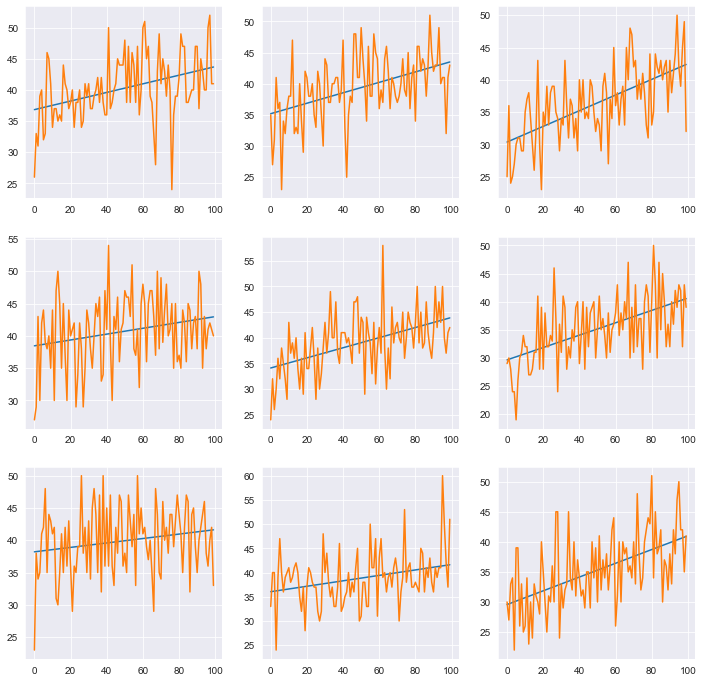

In [306]:
lr_l = [0.1, 0.3, 0.5]
exp_rate_l = [0.3,0.5,1]
combos = list(itertools.product(lr_l,exp_rate_l))
f, axes = plt.subplots(3, 3, figsize=(12, 12))

for index, combo in enumerate(combos):
    sol = BlackJackSolution(lr=combo[0],exp_rate=combo[1])
    print(f'Playing Set {index}...')
    sol.play(10000)
    
    countWindow = 100
    sumGames = np.add.reduceat(sol.gameTrack, np.arange(0, len(sol.gameTrack), countWindow))
    
    # Create regression 
    coef = np.polyfit(np.arange(len(sumGames)),sumGames,1)
    poly1d_fn = np.poly1d(coef)
    
    sns.lineplot(data=poly1d_fn(np.arange(len(sumGames))), ax=axes[math.floor(index/3),index % 3])
    sns.lineplot(data=sumGames,ax=axes[math.floor(index/3),index % 3])

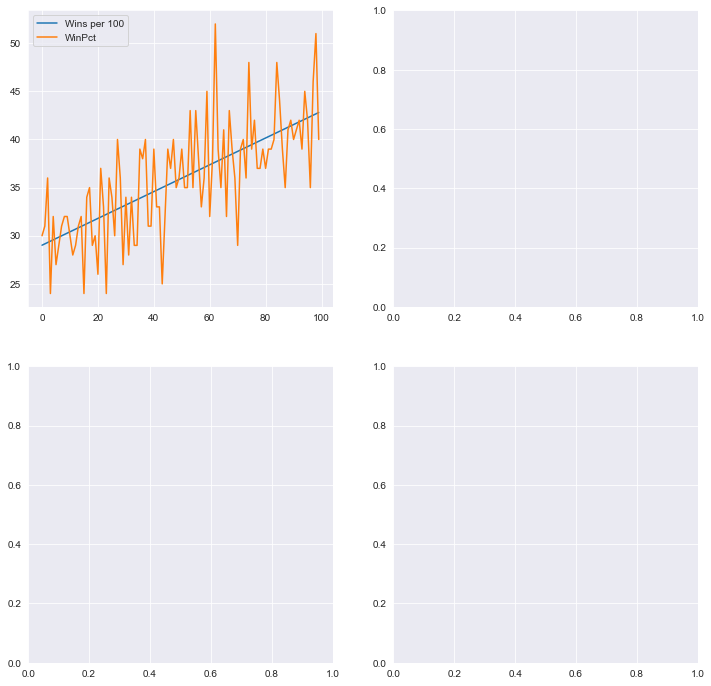

In [291]:
f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.set_style("darkgrid")
sns.lineplot(data=poly1d_fn(np.arange(len(sumGames))), label=f"Wins per {countWindow}", ax=axes[0,0])
sns.lineplot(data=sumGames,label='WinPct',ax=axes[0,0])

#plt.plot(sumGames)
#plt.plot(np.arange(len(sumGames)),poly1d_fn(np.arange(len(sumGames))),'--k')

In [307]:
sol.player_Q_Values

{(12, 1, True): {1: -0.193, 0: 0},
 (12, 1, False): {1: -0.303, 0: -0.867},
 (12, 2, True): {1: 0.694, 0: 0.875},
 (12, 2, False): {1: -0.598, 0: -0.961},
 (12, 3, True): {1: -0.149, 0: -0.5},
 (12, 3, False): {1: 0.044, 0: -0.951},
 (12, 4, True): {1: 0.253, 0: 0},
 (12, 4, False): {1: 0.387, 0: -0.918},
 (12, 5, True): {1: 0.438, 0: -0.688},
 (12, 5, False): {1: -0.933, 0: -0.916},
 (12, 6, True): {1: -0.685, 0: -0.75},
 (12, 6, False): {1: -0.932, 0: -0.405},
 (12, 7, True): {1: -0.458, 0: 0.344},
 (12, 7, False): {1: 0.252, 0: -0.591},
 (12, 8, True): {1: -0.135, 0: -0.5},
 (12, 8, False): {1: -0.637, 0: -0.98},
 (12, 9, True): {1: 0.142, 0: -0.75},
 (12, 9, False): {1: -0.844, 0: -0.989},
 (12, 10, True): {1: 0.008, 0: 0.91},
 (12, 10, False): {1: -0.459, 0: -0.997},
 (13, 1, True): {1: -0.44, 0: -0.812},
 (13, 1, False): {1: -0.677, 0: -0.871},
 (13, 2, True): {1: 0.348, 0: -0.375},
 (13, 2, False): {1: -0.506, 0: -0.975},
 (13, 3, True): {1: -0.523, 0: -0.391},
 (13, 3, False): 